### Overview
This notebook gives an example of how to construct a simple daily gas curve model using the curves package. The function build_daily_gas_curve, defined below, takes a collection of traded forward prices, bootstraps out and overlapping prices, and then interpolates to a smooth daily curve. A constant weekend shaping factor is used to provide shaping of weekend versus weekday prices in the final curve.

In [1]:
from curves import contract_period as cp
from curves import bootstrap_contracts, max_smooth_interp, adjustments, tension_spline
from datetime import date

In [15]:
def build_daily_gas_curve(contracts, weekend_ratio, tension, allow_redundancy=None, shaping_ratios=None, 
                                  shaping_spreads=None, front_1st_deriv=None, back_1st_deriv=None):
    piecewise_curve, bootstrapped_contracts = bootstrap_contracts(contracts, freq='D', allow_redundancy=allow_redundancy, 
                                        shaping_ratios=shaping_ratios, shaping_spreads=shaping_spreads)
    weekend_adjust = adjustments.dayofweek(default=1.0, saturday=weekend_ratio, sunday=weekend_ratio)
    smooth_curve, _ = tension_spline(bootstrapped_contracts, freq='D', tension=tension, discount_factor=lambda x: 1.0,
                                    mult_season_adjust=weekend_adjust)
    return smooth_curve, piecewise_curve, bootstrapped_contracts

##### Inputs for the daily gas curve model

In [16]:
weekend_ratio = 0.9


contracts = [
                ((date(2019, 1, 1), date(2019, 1, 2)), 32.7), # manually specified contract period
                (date(2019, 1, 1), date(2019, 1, 7), 29.3), # manually specified contract period
                (cp.q_1(2019), 22.1), 
                (date(2019, 1, 1), date(2019, 1, 31), 25.5), # January 2019
                (cp.feb(2019), 23.3),
                (cp.q_2(2019), 18.3),
                (cp.q_3(2019), 17.1),
                (cp.q_4(2019), 20.1),
                (cp.winter(2019), 22.4),
                (cp.summer(2020), 19.9),
                (cp.winter(2020), 21.8),
                (cp.gas_year(2020), 20.01)
            ]

ratios = [
            (cp.q_1(2021), cp.q_4(2020), 1.09),
            (cp.q_3(2020), cp.q_2(2020), 1.005)
        ]

spreads = [
            (cp.jan(2020), cp.feb(2020), 0.5),
        ]

back_end_slope = 0.1

#### Run Curve Calculations

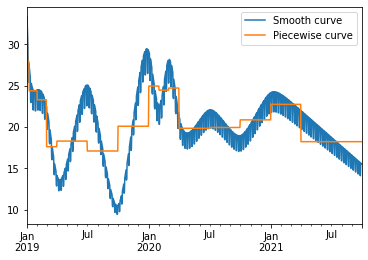

In [32]:
tension = 20.014
smooth_curve, piecewise_curve, bootstrapped_contracts = build_daily_gas_curve(contracts, weekend_ratio, tension, shaping_ratios=ratios,
                                                      shaping_spreads=spreads, back_1st_deriv=back_end_slope)

%matplotlib inline

smooth_curve.plot(legend=True)
ax = piecewise_curve.plot(legend=True)
ax.legend(['Smooth curve', 'Piecewise curve'])

In [35]:
import numpy as np
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/Jake/anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/Jake/anaconda3\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/Jake/anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/Jake/anaconda3\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/Jake/anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/Jake/anaconda3\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/Jake/anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/Jake/anaconda3\\Library\\include']
Supported SIMD extensions in this NumPy install:
    baselin

#### Display Results

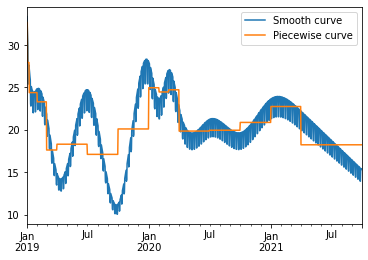

In [19]:
%matplotlib inline

smooth_curve.plot(legend=True)
ax = piecewise_curve.plot(legend=True)
ax.legend(['Smooth curve', 'Piecewise curve'])

11.68158693275553

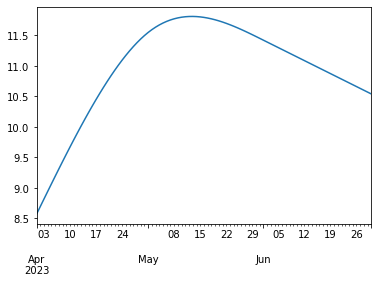

In [6]:
import pandas as pd
from IPython.display import display

freq = 'D'
time_zone = None #'Europe/London'
flat_price = 10.5
num_contracts = 3
monthly_index = pd.period_range(start='2023-04-01', periods=num_contracts, freq='M')
monthly_curve = pd.Series(data=[10.2, 11.69, 10.98], index=monthly_index)

def tension(p):
    return 0.00010
# Act
daily_curve, spline_params = tension_spline(monthly_curve, freq=freq, tension=tension, time_zone=time_zone,
                                                    discount_factor=lambda x: 1.0)
daily_curve.plot()
#print(daily_curve.to_string())
daily_curve['2023-05-01':'2023-06-01'].mean()